In [1]:
import pandas as pd
import numpy as np
import time
import torchvision
from torchvision import models
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import random
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug import augmenters as iaa
from skimage import io, transform


print(os.listdir("input"))

['test.csv', 'sample_submission.csv', 'train_images.zip', 'test_images.zip', 'train.csv', 'test_images', 'train_images']


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
num_classes = 1
seed_everything(24)
lr          = 1e-3
IMG_SIZE    = 224
BS = 16
model_name = "model/grayscale.bin"

#20190815 11:13pm: changed sigmax to 10, added color jitter and increase epos to 25

In [4]:
train      = 'input/train_images/'
test       = 'input/test_images/'
train_csv  = pd.read_csv('input/train.csv')

train_df, val_df = train_test_split(train_csv, test_size=0.1, random_state=98)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [5]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

     
class MyDataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):
        img_name = os.path.join('input/train_images', self.df.loc[idx, 'id_code'] + '.png')
        image = cv2.imread(img_name)
        # keep the green channel only
        image[:,:,0] = 0
        image[:,:,2] = 0
        image = crop_image_from_gray(image)
        image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image , (0,0) , 30), -4 , 128)
        image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
         
        label = torch.tensor(self.df.loc[idx, 'diagnosis'])
        
        return image, label

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloader, total=int(len(dataloader)))
            # Iterate over data.
            for inputs, labels in tk0:
                labels = labels.view(-1, 1)       
                
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                   
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(dataloader)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
tsfm = transforms.Compose([    
                           #transforms.Resize(255),
                           #transforms.Grayscale(num_output_channels=3),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomVerticalFlip(),
                           #transforms.RandomRotation((-120, 120)),
                           #transforms.ColorJitter(contrast=[1.5,1.5]),
                           transforms.Resize((IMG_SIZE,IMG_SIZE)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])

train_set = MyDataset(train_df, transform = tsfm)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True, num_workers=4)

val_set       = MyDataset(val_df, transform = tsfm)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BS, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


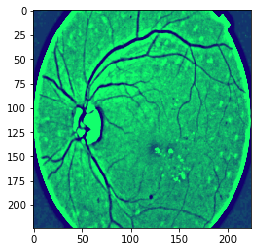

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


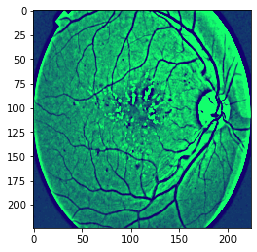

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


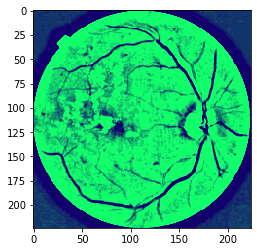

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


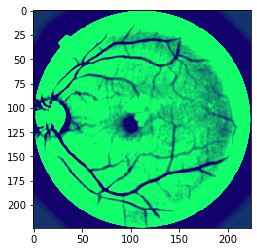

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


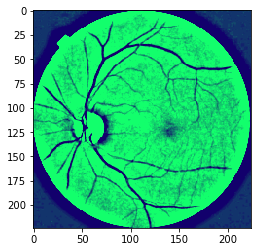

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


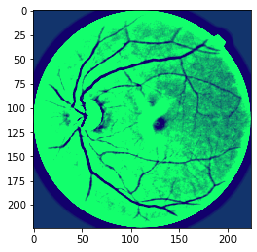

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


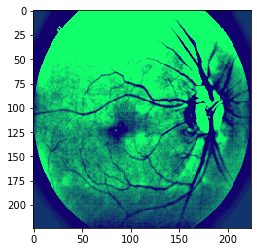

In [8]:
import matplotlib.pyplot as plt
for batch_idx, (inputs, labels) in enumerate(train_set):
    inputs = inputs.permute(1, 2, 0)
    
    plt.figure()
    plt.imshow(inputs.numpy())
    plt.show()
    
    if batch_idx>5:
        break
        
        
        

In [9]:
device = torch.device("cuda:0")
torch.cuda.is_available()

True

In [10]:
# model = models.densenet121(pretrained=True)
# num_features = model.classifier.in_features
# model.classifier = nn.Linear(num_features, num_classes)
# model.cuda()

model = models.resnet101(pretrained=True)
#num_features = model.fc.in_features
#model.fc = None
model.fc = nn.Sequential(
                          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                          nn.Dropout(p=0.25),
                          nn.Linear(in_features=2048, out_features=2048, bias=True),
                          nn.ReLU(),
                          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                          nn.Dropout(p=0.5),
                          nn.Linear(in_features=2048, out_features=1, bias=True),
                         )
model.avg_pool = nn.AdaptiveAvgPool2d(1)
model.cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10)


In [12]:
criterion = nn.MSELoss()

model_ft = train_model(model, criterion, optimizer, scheduler,
                       num_epochs=25)

torch.save(model_ft.state_dict(), model_name)

Epoch 0/24
----------



train Loss: 17.8050



val Loss: 15.1877

Epoch 1/24
----------


KeyboardInterrupt: 

In [ ]:
model = models.densenet121(pretrained=None)
model.load_state_dict(torch.load(model_name))
model.classifier = nn.Linear(num_features, 1)


for param in model.parameters():
    param.requires_grad = False

model.eval()
model.cuda()


In [ ]:
test_pred = np.zeros((len(val_df), 1))



for i, data in tqdm(enumerate(val_loader)):
    images, labels = data
    images = images.to(device, dtype=torch.float)
    outputs = model(images) 
    
    test_pred[i * BS:(i + 1) * BS] += outputs.detach().cpu().squeeze().numpy().reshape(-1, 1)

output = test_pred

val_df['pred'] = test_pred
val_df.sort_values('pred')

In [ ]:
import numpy as np
import pandas as pd
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json


class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
optR = OptimizedRounder()
optR.fit(val_df['pred'], val_df['diagnosis'])
coefficients = optR.coefficients()
valid_predictions = optR.predict(val_df['pred'], coefficients)
#test_predictions = optR.predict(test_predictions, coefficients)

In [ ]:
coefficients

In [ ]:
metrics.cohen_kappa_score(val_df['diagnosis'], valid_predictions, weights='quadratic')

In [ ]:
val_df['diagnosis'].value_counts()/val_df.shape[0]

In [ ]:
train_df['diagnosis'].value_counts()/train_df.shape[0]

In [20]:
class MyTestDataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):
        img_name = os.path.join('input/test_images', self.df.loc[idx, 'id_code'] + '.png')
        #p = self.df.id_code.values[idx]
        #p_path = expand_path(p)
        #image = cv2.imread(p_path)
        image = cv2.imread(img_name)
        image = crop_image_from_gray(image)
        image = cv2.addWeighted (image, 4, cv2.GaussianBlur(image , (0,0) , 30) ,-4 ,128)
        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
         
        #label = torch.tensor(self.df.loc[idx, 'diagnosis'])
        
        return image

In [21]:
sample = pd.read_csv('input/sample_submission.csv')

test_dataset = MyTestDataset(sample, transform = tsfm)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [22]:
model = models.densenet121(pretrained=None)
model.load_state_dict(torch.load(model_name))
model.classifier = nn.Linear(num_features, 1)

for param in model.parameters():
    param.requires_grad = False


model.eval()
model.cuda()



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [23]:
BS = 1
test_pred = np.zeros((len(test_dataset), 1))
for i, data in tqdm(enumerate(test_loader)):
    images = data
    images = images.to(device, dtype=torch.float)
    outputs = model(images) 
    test_pred[i * BS:(i + 1) * BS] += outputs.detach().cpu().squeeze().numpy().reshape(-1, 1)

In [24]:
test_pred

array([[1.95568621],
       [2.26165128],
       [2.02388191],
       ...,
       [1.90256405],
       [2.72796226],
       [0.26629406]])

In [25]:
coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(test_pred):
    if pred < coef[0]:
        test_pred[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        test_pred[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        test_pred[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        test_pred[i] = 3
    else:
        test_pred[i] = 4


sample = pd.read_csv("input/sample_submission.csv")
sample.diagnosis = test_pred.astype(int)
sample.to_csv("submission.csv", index=False)

In [26]:
sample.groupby('diagnosis')['id_code'].count()/sample.shape[0]

diagnosis
0    0.098548
1    0.340249
2    0.445539
3    0.112033
4    0.003631
Name: id_code, dtype: float64

In [27]:
train_df.groupby('diagnosis')['id_code'].count()/train_df.shape[0]

diagnosis
0    0.494689
1    0.102883
2    0.268892
3    0.052504
4    0.081032
Name: id_code, dtype: float64

In [28]:
sample.head(20)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,1
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,1
8,01499815e469,4
9,0167076e7089,1
